In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import datetime as dt
import random as ran
from sklearn.metrics.pairwise import euclidean_distances as euc
from functools import reduce
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs
from IPython.display import clear_output, Markdown, display

In [3]:
# 1. load_excel

# data/apt_all.xlsx
# data/apt_1.xlsx
# data/apt_3.xlsx
# data/apt_4.xlsx
# data/apt_std_nugin_1_3.xlsx

data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

In [4]:
# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

In [5]:
# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart
    
crs.utils.print_apt_info(_month, month_df, APT)

hh, anal = crs.utils.get_analysis_df(_month,month_df, APT)
anal.head()

APT : 44,434kWh (평균 사용량: 411kWh)
		6,439,540원
세대부 : 31,104kWh (70%) (평균 사용량: 288kWh)
		3,798,980원
공용부 : 13,330kWh (30%) (평균 사용량: 123kWh)
		2,640,560원


,기본요금,전력량요금,기후환경요금,연료비 조정액,VAT,전력산업기반기금,기본요금 + 전력량요금
APT,654480,4907088,235224,-133164,566363,209550,5561568
세대부,197480,3118820,164805,-93312,334205,123150,3316300
공용부,457000,1788268,70419,-39852,232158,86400,2245268
세대부 / APT percentage,30,64,70,70,59,59,60
공용부 / APT percentage,70,36,30,30,41,41,40


# What is public fee?
---
- 공용부의 요금은 아파트 전체 사용요금에서 세대부의 요금을 뺀 나머지가 공용부의 요금이 되어지기 때문에 전기요금의 기본 구성요소인 기본요금, 전력량요금, 기후환경요금, 연료비 조정액 등으로 표현되어지지 않는다.
- APT 평균 사용량에 의하여 산정된 요금에서 세대부의 요금을 뺀 나머지가 공용부의 요금이 되어짐으로, 세대부 가구구성이랑 관련이 있다.
- 세대부의 가구들이 APT평균사용량에 의하여 산정된 요금을 각 각의 사용량만큼 가지고 간다라는 의미에서 **'수거'의 개념을 사용하여 공용부의 전기요금 구성요소들이 어떤 특징을 보여주는지에 대해서 살펴보기로 한다.**

#### 공용부 전기요금 이론을 확립하기 위한 연구

# 1. 기본요금
---
- 세대부 사용량 구성이 고정되어있다는 조건하에 조건 주택용 고압 요금표에서 특정 사용량에 대해 고정된 기본요금을 부여하듯이, 공용부의 기본요금도 누진단계별로 고정되어 있다.

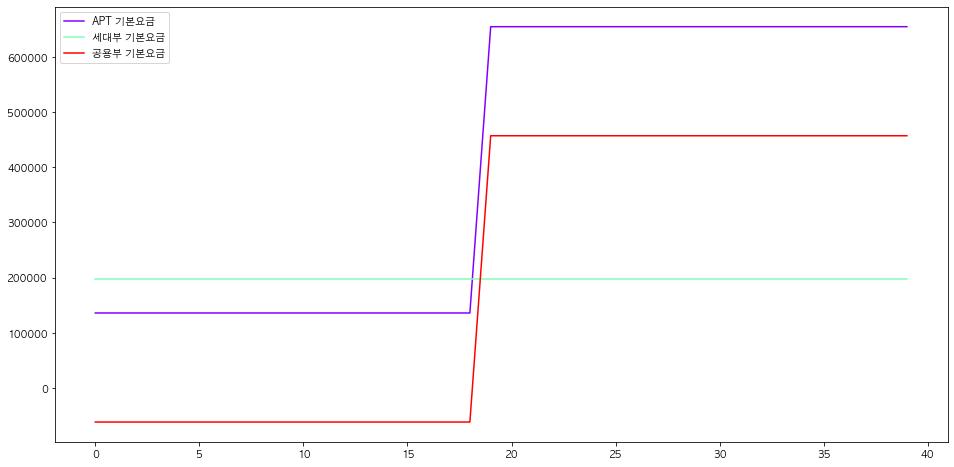

,10%,11%,12%,13%,14%
APT,136080,136080,136080,136080,136080
세대부,197480,197480,197480,197480,197480
공용부,-61400,-61400,-61400,-61400,-61400


In [7]:
basic_df = pd.DataFrame(index=['APT', '세대부', '공용부'])

for PUBLIC_PERCENTAGE in range(10, 50, 1):
    APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)
    _, anal_df = crs.utils.get_analysis_df(_month, month_df, APT)
    
    basic_df["{}%".format(PUBLIC_PERCENTAGE)] = \
        anal_df['기본요금'].values[:3]
    
plt.figure(figsize=(16,8))
palette = plt.cm.get_cmap("rainbow", len(basic_df))
for idx,(index_name, row) in enumerate(basic_df.iterrows()):
    plt.plot(row.values, c=palette(idx), 
             label="{} 기본요금".format(index_name))
plt.legend(loc='upper left')
plt.show()

basic_df[basic_df.columns[:5]]

## 기본요금에서의 수거의 개념
- 공용부의 기본요금은 가구 사용량 구성에 따라 변한다.
- APT 평균사용량에 대한 기본요금은 [APT 평균사용량 기본요금 * 가구 수]로 쉽게 예측이 가능하지만, 공용부 기본요금은 세대부에서 기본요금을 얼마나 **수거**해갈지 모르기 때문에, 쉽게 예측이 불 가능하다.
- **공용부의 기본요금을 예측하기 위해서는 세대부의 사용량 구성을 누진단계별로 그룹화해주는 과정이 필요하다.**
    - **이후 APT 평균사용량에 대한 기본요금과의 차를 구하면 그것이 공용부의 기본요금이다.**

In [52]:
step_df = month_df.copy()
step_df['누진단계'] = np.array([crs.utils.get_nugin_step(_, calc.fee) 
                   for _ in month_df['usage (kWh)']]) + 1

step_count = pd.DataFrame(
    step_df['누진단계'].groupby(step_df['누진단계']).count())
step_count.columns = ['가구 수']
step_count['기본요금'] = [_[2] for _ in calc.fee]
step_count['토탈'] = \
    step_count.apply(lambda x: x['가구 수'] * x['기본요금'], axis=1)

step_count.loc['세대부 토탈'] = step_count.sum(axis=0)

step_count

,가구 수,기본요금,토탈
누진단계,,,
1,20,730,14600
2,73,1260,91980
3,15,6060,90900
세대부 토탈,108,8050,197480


In [53]:
_APT = round(APT / len(month_df))
crs.utils.get_nugin_step(_APT, calc.fee)

2

In [54]:
rs_step_count = step_count.reset_index()

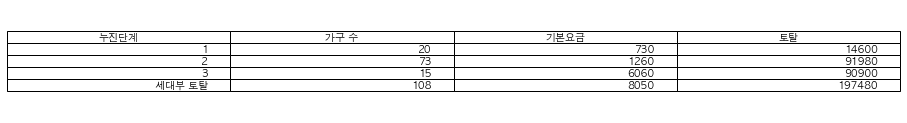

In [65]:
plt.figure(figsize=(16, 2))
plt.table(cellText=rs_step_count.values,
           colLabels=rs_step_count.columns,
           loc="center")
plt.axis('tight')
plt.axis('off')

plt.show()

# 2. 전력량요금
---
- 공용부의 전력량요금은 APT 평균사용량 안에서 세대부 평균사용량 이후의 누진단계부터 가격 산정이 시작된다.

# 3. 기후환경요금, 연료비 조정액
---
- 머라머라

In [42]:
rs_step_count.values

array([[1, 20, 730, 14600],
       [2, 73, 1260, 91980],
       [3, 15, 6060, 90900],
       ['세대부 토탈', 108, 8050, 197480]], dtype=object)